In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline  

def create_paired_dataset(input_file, output_file=None, label=None):
    # Load the original matrix
    x = np.load(input_file)
    if label == 0:
        y = np.zeros(x.shape[0], dtype=int)
    elif label == 1:
        y = np.ones(x.shape[0], dtype=int)
    
    # Create the paired dataset
    paired_dataset = (x, y)
    
    # Optionally save the paired dataset
    if output_file:
        np.save(output_file, paired_dataset)
    
    return paired_dataset

def get_accuracy(layers=None, activations_dir=None):
    accuracy = []
    for layer in layers:
        cautious_x, cautious_y = create_paired_dataset(os.path.join(activations_dir, f"deepseek_layer_{layer}_cautious_activations.npy"), label=0)
        non_cautious_x, non_cautious_y = create_paired_dataset(os.path.join(activations_dir, f"deepseek_layer_{layer}_noncautious_activations.npy"), label=1)
        X = np.vstack((cautious_x, non_cautious_x))
        y = np.concatenate((cautious_y, non_cautious_y))

        # Create a permutation of indices
        shuffle_indices = np.random.permutation(len(y))
        # Use these indices to shuffle both X and y in the same way
        X = X[shuffle_indices]
        y = y[shuffle_indices]

        # 5. Split into train and test sets (75% train, 25% test)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42, stratify=y
        )

        # print(f"Training set size: {X_train.shape[0]} samples")
        # print(f"Test set size: {X_test.shape[0]} samples")
        # print(f"Feature vector size: {X_train.shape[1]} dimensions")
        # print(f"Class distribution in training: {np.bincount(y_train)}")
        # print(f"Class distribution in testing: {np.bincount(y_test)}")
        # Train a logistic regression classifier
        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(X_train, y_train)

        # Evaluate the model
        y_pred = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))

    return accuracy

In [2]:
layers = [3,7,11,15,17,19,23,27,31]
baseline_dir = "../activations/baseline/"
cot150_dir = "../activations/cot150"
baseline_variations = []
cot150_variations = []
for x in range(10):
    baseline_variations.append(get_accuracy(layers, baseline_dir))
    cot150_variations.append(get_accuracy(layers, cot150_dir))
baseline_mean = np.mean(baseline_variations, axis=0)
cot150_mean = np.mean(cot150_variations, axis=0)
baseline_std = np.std(baseline_variations, axis=0)
cot150_std = np.std(cot150_variations, axis=0)

print(baseline_mean)
print(cot150_mean)

[0.68113208 0.71698113 0.70566038 0.71886792 0.69622642 0.71698113
 0.73773585 0.72830189 0.73962264]
[0.66792453 0.79245283 0.86037736 0.85849057 0.87735849 0.86415094
 0.86037736 0.85849057 0.81132075]


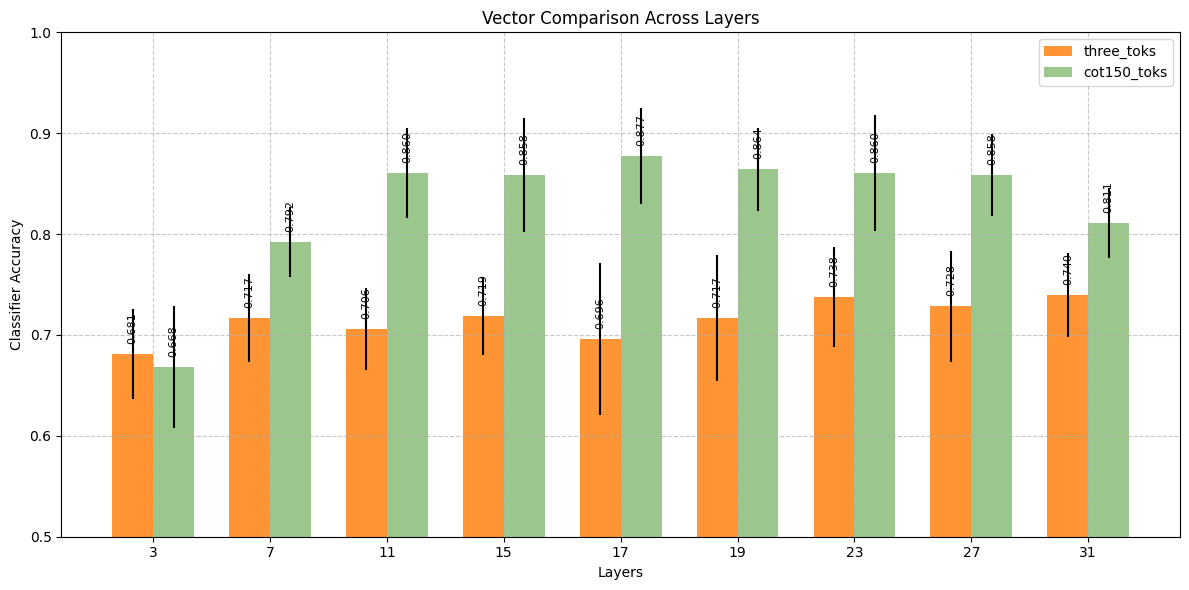

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(layers))
r2 = [x + bar_width for x in r1]

# Create the bars
ax.bar(r1, baseline_mean, yerr=baseline_std, width=bar_width, label='three_toks', color='#ff7901', alpha=0.8)
ax.bar(r2, cot150_mean, yerr=cot150_std, width=bar_width, label='cot150_toks', color='#83ba6f', alpha=0.8)

# Add labels, title and custom x-axis tick labels
ax.set_xlabel('Layers')
ax.set_ylabel('Classifier Accuracy')
ax.set_title('Vector Comparison Across Layers')
ax.set_xticks([r + bar_width/2 for r in range(len(layers))])
ax.set_xticklabels(layers)

# Set y-axis range to highlight differences
ax.set_ylim([0.5, 1.0])

# Add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Add a legend
ax.legend()

# Add value annotations
for i, v in enumerate(baseline_mean):
    ax.text(r1[i], v + 0.01, f'{v:.3f}', ha='center', va='bottom', rotation=90, fontsize=8)

for i, v in enumerate(cot150_mean):
    ax.text(r2[i], v + 0.01, f'{v:.3f}', ha='center', va='bottom', rotation=90, fontsize=8)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig('../figures/classifier_accuracy_comparison.png', dpi=300)
plt.show()